In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm
import os
os.chdir('..')
os.getcwd()

'c:\\Users\\jimal\\OneDrive\\Documents\\AI\\reinforcement-learning'

# Asynchronous advantage actor-critic (A3C)

[Original paper](https://arxiv.org/pdf/1602.01783.pdf)

[Implementation here](a3c.py)
- Uses action-advantage estimate ($A^{\pi}(s_t, a_t)$) like with VPG
- Advantage estimate uses n-step TD estimates instead of full episode returns
  - Introduces **critic** to model, since n-step TD estimate uses learning value function approximator
  - Less variance, but higher bias and worse convergence properties
- Multiple actor-critics run asynchronously to optimize a single shared model with the process loop:
  - Copy parameters $\theta$, $\theta_v$ from shared policy/value model
  - Interact with environment for $n$ steps, keeping track of state $s_t$, action $a_t$, and reward $r_t$ at each step
  - After $n$ steps, for each step $t$ in $T, T+1, ..., T+n$:
    - Calculate n-step TD estimate: $R^{(n)}_t = r_t + \gamma r_{t+1} + ... + \gamma^n r_{T+n} + V(s_{T+n+1};\theta_v)$
    - Calculate advantage estimate: $A^{(n)}_t = R^{(n)}_t - V(s_t;\theta_v)$
    - Calculate policy gradient: $\nabla_\theta J(\theta) = A^{(n)}_t \nabla_\theta \log \pi_(a_t|s_t;\theta)$
    - Calculate value estimator loss $\propto A_t^2$
  - Step and update shared policy/value parameters with policy gradient and value estimator loss

![Alt text](image.png)

In [2]:
import pickle
from scripts.a3c import FCDAP, FCV
res = {}
with open('testfiles/a3c_lunarlander.results', 'rb') as file:
#with open('a3c.results', 'rb') as file:
    res = pickle.load(file)

In [3]:
res['best_moving_avg_return']

tensor([201.8681])

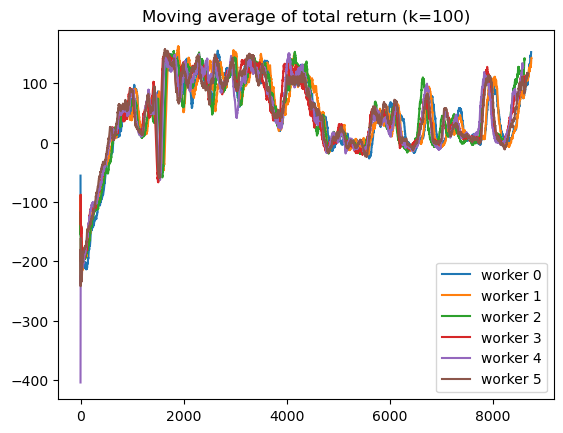

In [4]:
episode_returns = res['episode_returns']
for rank, returns_tensor in enumerate(episode_returns):
    plt.plot(range(len(returns_tensor)), [returns_tensor[max(0,x-100):x+1].mean() for x in range(len(returns_tensor))], label=f'worker {rank}')
plt.title('Moving average of total return (k=100)')
plt.legend()

In [10]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0]
            else:
                action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

env = gym.make('LunarLander-v2', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, video_folder='recordings/a3c', name_prefix=f'a3c_lunarlander_best', disable_logger=False)
run_discrete_policy_model(env, res['best_model'], num_episodes=1, stochastic=True)

c:\Users\jimal\Anaconda3\envs\rl_env\lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\a3c folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\a3c\a3c_lunarlander_best-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\a3c\a3c_lunarlander_best-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\a3c\a3c_lunarlander_best-episode-0.mp4


[268.8435554250239]

In [19]:
env.close()

# Generalized advantage estimation (GAE)

[Original paper](https://arxiv.org/pdf/1506.02438.pdf)

[Implementation here](a3c_gae.py)
- Recall the original n-step TD advantage estimate, for each step $t$ in $T, T+1, ..., T+n$:
  - Calculate n-step TD estimate: $R^{(n)}_t = r_t + \gamma r_{t+1} + ... + \gamma^n r_{T+n} + V(s_{T+n+1};\theta_v)$
  - Calculate advantage estimate: $A^{(n)}_t = R^{(n)}_t - V(s_t;\theta_v)$
- Let $A^{(1)}_t= -V(s_t) + r_t + \gamma V(s_{t+1})= \delta_t$:
  - $A^{(2)}_t=-V(s_t) + r_t + \gamma r_{t+1}+ \gamma^2 V(s_{t+2}) = (-V(s_t) + r_t + \gamma V(s_{t+1})) + (-\gamma V(s_{t+1})+\gamma r_{t+1}+ \gamma^2 V(s_{t+2})) = \delta_t + \gamma\delta_{t+1}$
  - $A^{(k)}_t=\sum_{l=0}^k \gamma^l \delta_{t+l}$
  - $\lim_{k\to\infty} A^{(k)}_t=\sum_{l=0}^\infty \gamma^l \delta_{t+l}=-V(s_t)+\sum_{l=0}^\infty\gamma^l r_{t+l}$ which is just the full Monte Carlo return minus value function baseline (VPG!)
- The generalized advantage estimator $A_t^{\text{GAE}(\lambda)}$ is the exponentially-weighted average of these n-step advantage estimates
  - $A_t^{\text{GAE}(\lambda)}=(1-\lambda)(A^{(1)}_t+\lambda A^{(2)}_t+...)=...=\sum_{l=0}^\infty(\gamma\lambda)^l \delta_{t+l}=\sum_{l=0}^\infty(\gamma\lambda)^l R^{(1)}_{t+l} - V(s_{t+l})$
  - $0<\lambda<1$ controls the bias and variance of the estimator
    - $\lambda\to 1$ (full n-step) lowers bias, but has higher variance
    - $\lambda\to 0$ (single-step) lowers variance, but induces bias

In [27]:
import pickle
from scripts.a3c_gae import FCDAP, FCV
res = {}
with open('testfiles/a3c_gae.results', 'rb') as file:
    res = pickle.load(file)

In [28]:
res['best_moving_avg_return']

tensor([500.])

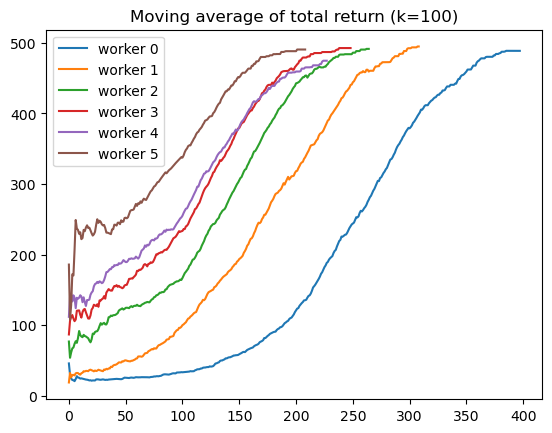

In [29]:
episode_returns = res['episode_returns']
for rank, returns_tensor in enumerate(episode_returns):
    plt.plot(range(len(returns_tensor)), [returns_tensor[max(0,x-100):x+1].mean() for x in range(len(returns_tensor))], label=f'worker {rank}')
plt.title('Moving average of total return (k=100)')
plt.legend()

In [30]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0]
            else:
                action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, res['best_model'], num_episodes=1, stochastic=True)

[500.0]

In [31]:
env.close()

# Advantage actor-critic (A2C)

[Implementation here](a2c.py)

- Synchronous version of A3C
- Single actor-critic model interacts with multiple (vectorized) environments and gathers experiences
- Synchronized batch processing/optimization step can easily take advantage of GPU resources to speed up training

In [3]:
import pickle
from scripts.a2c import FCAC
res = {}
with open('testfiles/a2c.results', 'rb') as file:
    res = pickle.load(file)

In [8]:
len(res['episode_returns'])

8

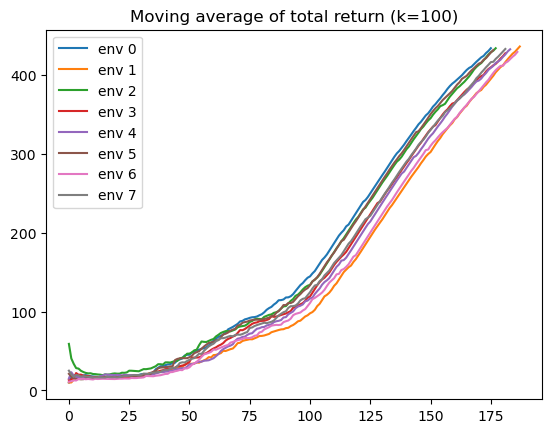

In [13]:
episode_returns = res['episode_returns']
for rank, returns in enumerate(episode_returns):
    plt.plot(range(len(returns)), [np.mean(returns[max(0,x-100):x+1]) for x in range(len(returns))], label=f'env {rank}')
plt.title('Moving average of total return (k=100)')
plt.legend()

In [37]:
def run_discrete_policy_model(env, model, gamma=1.0, num_episodes=1, stochastic=True):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            if stochastic:
                action = model.select_action(state)[0].item()
            else:
                action = model(state)[0].detach().max(0).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

env = gym.make('CartPole-v1', render_mode='human')
run_discrete_policy_model(env, res['best_model'], num_episodes=1, stochastic=True)

[500.0]

In [ ]:
env.close()